https://analyzecore.com/2014/10/17/cart-analysis-r/

In this post, we will review a very interesting type of visualization – the Multi-layer Pie Chart – and use it for one of the marketing analytics tasks – the shopping carts analysis.

We will go from the initial data processing to the shopping carts analysis visualization. I will share the R code in that you shouldn’t write code for every layer of a chart. You can also find an example of how to create a Multi-layer Pie Chart here.

Ok, let’s suppose we have a list of first orders/carts that were bought by our clients. Each order consists one or several products (or category of products). Our task is to visualize a relationship between products and see the share of orders that includes each product or combination of products. The Multi-layer Pie Chart **can help us to draw each product and its intersections with others.**

In [1]:
# loading libraries
library(dplyr)
library(reshape2)
# install.packages("plotrix")
library(plotrix)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



We will simulate an example of the data set. Suppose we sell 4 products (or product categories): a, b, c and d and each product can be sold with a different probability. Also, a client can purchase any combinations of products, e.g. “a” or “a,b,a,d” and so on. Let’s do this with the following code

In [2]:
# creating an example of orders
set.seed(15)
df <- data.frame(
    orderId=sample(c(1:1000), 5000, replace=TRUE),
    product=sample(c('NULL','a','b','c','d'), 5000, replace=TRUE,
            prob=c(0.15, 0.65, 0.3, 0.15, 0.1)))

df <- df[df$product!='NULL', ]

In [3]:
head(df)

,orderId,product
1,603,a
2,196,c
4,651,a
5,368,a
6,989,b
7,816,a


After this, we will process data for creating data frame for analysis. Specifically, we will:

* remove the duplicates. For example, if the order consists of more than one similar product (“a,b,a,d”), we want to exclude the effect of quantity,
* combine products to the new feature ‘cart’ that will include all unique products in the cart,
* calculate number of carts (‘num’ column).

In [15]:
# processing initial data
# we need to be sure that product's names are unique
df$product <- paste0("#", df$product, "#")
 
prod.matrix <- df %>%
 # removing duplicated products from each order
 group_by(orderId, product) %>%
 arrange(product) %>%
 unique() %>%
 # combining products to cart and calculating number of products
 group_by(orderId) %>%
 summarise(cart=paste(product,collapse=";"),
 prod.num=n()) %>%
 # calculating number of carts
 group_by(cart, prod.num) %>%
 summarise(num=n()) %>%
 ungroup()

In [16]:
# df %>%
#  # removing duplicated products from each order
#  group_by(orderId, product) %>%
#  arrange(product) %>% 
#  unique() %>% 
# group_by(orderId) %>%
# summarise(cart=paste(product,collapse=";"),
#  prod.num=n()) %>%
# group_by(cart, prod.num) %>%
# summarise(num=n())

From this point, we start working on our Multi-layer Pie Chart. My idea is to place orders that include one product into the core of the chart. Therefore, we’ve calculated the total number of products in each combination (‘prod.num’ value) and will split data frame for two data frames: the first one (one.prod) that will include carts with one product and the second one (sev.prod) with more than one product.

In [17]:
# calculating total number of orders/carts
tot <- sum(prod.matrix$num)
 
# spliting orders for sets with 1 product and more than 1 product
one.prod <- prod.matrix %>% filter(prod.num == 1)
 
sev.prod <- prod.matrix %>%
 filter(prod.num > 1) %>%
 arrange(desc(prod.num))

Therefore, the data is ready for plotting. We will define parameters for the chart with the following code:

In [19]:
# defining parameters for pie chart
iniR <- 0.2 # initial radius
cols <- c("#ffffff", "#fec44f", "#fc9272", "#a1d99b", "#fee0d2",
 "#2ca25f", "#8856a7", "#43a2ca", "#fdbb84", "#e34a33",
 "#a6bddb", "#dd1c77", "#ffeda0", "#756bb1")

prod <- df %>%
 select(product) %>%
 arrange(product) %>%
 unique()
prod <- c('NO', c(prod$product))
colors <- as.list(setNames(cols[ c(1:(length(prod)))], prod))

Note: we’ve defined the color palette with fourteen colors including white color for spaces. This means if you have more than thirteen unique products in the data set, you need to add extra colors. Finally, we will plot the Multi-layer Pie Chart with the following code:

In case you want to add some statistics on plot, e.g. a total number of each combination or share of combinations in total amount, we just need to create this table and add it on the plot with the following code:

In [ ]:
# creating a table with the stats
stat.tab <- prod.matrix %>%
 select(-prod.num) %>%
 mutate(share=num/tot) %>%
 arrange(desc(num))
 
library(scales)
stat.tab$share <- percent(stat.tab$share) # converting values to percents

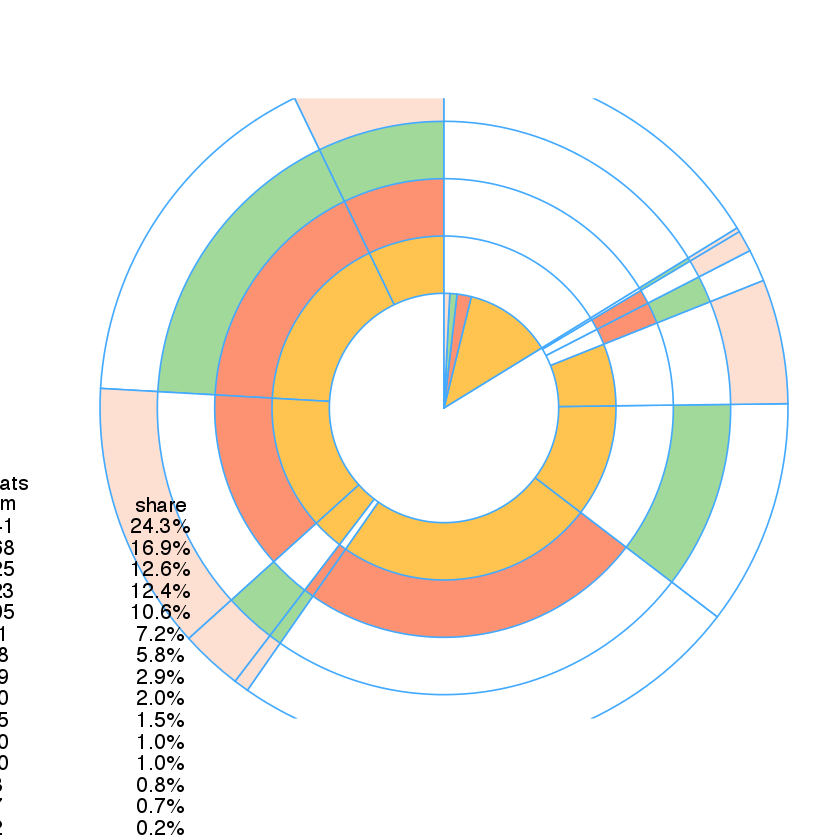

In [27]:
# 0 circle: blank
pie(1, radius=iniR, init.angle=90, col=c('white'), border = NA, labels='')
 
# drawing circles from last to 2nd
for (i in length(prod):2) {
 p <- grep(prod[i], sev.prod$cart)
 col <- rep('NO', times=nrow(sev.prod))
 col[p] <- prod[i]
 floating.pie(0,0,c(sev.prod$num, tot-sum(sev.prod$num)), radius=(1+i)*iniR, startpos=pi/2, col=as.character(colors [ c(col, 'NO')]), border="#44aaff")
}
 
# 1 circle: orders with 1 product
floating.pie(0,0,c(tot-sum(one.prod$num),one.prod$num), radius=2*iniR, startpos=pi/2, col=as.character(colors [ c('NO',one.prod$cart)]), border="#44aaff")
 
# legend
legend(1.5, 2*iniR, gsub("_"," ",names(colors)[-1]), col=as.character(colors [-1]), pch=19, bty='n', ncol=1)
# adding a table with the stats
addtable2plot(-2.5, -1.5, stat.tab, bty="n", display.rownames=FALSE,
hlines=FALSE, vlines=FALSE, title="The stats")

Therefore, we’ve studied how The Multi-layer Pie Chart can help us to draw each product and its intersections with others.